In [518]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error

## Load up the data

In [530]:
df = pd.read_csv('../combined_data.csv', index_col=0)
deaths_df = df.drop(['new_cases'], axis=1)
deaths_df.loc[deaths_df['new_deaths'] < 0, 'new_deaths'] = 0
deaths_df.head()

,Date,no2,ozone,pm25,County,new_deaths
0,2020-01-26,0.015,0.034,7.3,Alameda,0.0
1,2020-01-27,0.024,0.032,9.9,Alameda,0.0
2,2020-01-28,0.025,0.033,9.7,Alameda,0.0
3,2020-01-29,0.022,0.024,11.8,Alameda,0.0
4,2020-01-30,0.022,0.021,10.2,Alameda,0.0


## County average analysis

In [531]:
deaths_df[deaths_df['Date'] > '2020-07-01'].groupby(['County']).mean().sort_values(by=['new_deaths'], ascending=False)[:10]

,no2,ozone,pm25,new_deaths
County,,,,
Los_Angeles,0.026634,0.045328,26.628415,38.000000
Orange,0.020579,0.037716,15.476503,8.360656
Riverside,0.015984,0.052880,21.441530,8.316940
San_Bernardino,0.034137,0.057432,21.882514,6.486339
San_Diego,0.014967,0.045197,18.016940,6.349727
Sacramento,0.012284,0.034738,21.831694,4.311475
San_Joaquin,0.011699,0.033590,22.414208,3.267760
Stanislaus,0.010301,0.031863,22.158470,3.125683
Fresno,0.023153,0.034634,32.427322,3.120219


## Create historical features

In [521]:
def nth_day_feature(df, feature, n):
    rows = df.shape[0]
    nth_prior_measurement = [None]*n + [df[feature][i-n] for i in range(n, rows)]
    col_name = f'{feature}_{n}'
    df[col_name] = nth_prior_measurement

In [522]:
for feature in deaths_df.columns:
    if 'Date' in feature:
        continue
    if 'County' in feature:
        continue
    for n in range(1,15):
        nth_day_feature(deaths_df, feature, n)

## Encode county features and remove nans

In [525]:
clean_df = pd.get_dummies(deaths_df, columns=['County'])
to_remove = ['no2', 'pm25', 'ozone']
clean_df = clean_df.drop(to_remove, axis=1)
clean_df = clean_df.dropna()
clean_df

,Date,new_deaths,no2_1,no2_2,no2_3,no2_4,no2_5,no2_6,no2_7,no2_8,...,County_San_Mateo,County_Santa_Barbara,County_Santa_Clara,County_Solano,County_Sonoma,County_Stanislaus,County_Sutter,County_Tulare,County_Ventura,County_Yolo
14,2020-02-09,0.0,0.015,0.024,0.028,0.030,0.020,0.014,0.009,0.020,...,0,0,0,0,0,0,0,0,0,0
15,2020-02-10,0.0,0.005,0.015,0.024,0.028,0.030,0.020,0.014,0.009,...,0,0,0,0,0,0,0,0,0,0
16,2020-02-11,0.0,0.027,0.005,0.015,0.024,0.028,0.030,0.020,0.014,...,0,0,0,0,0,0,0,0,0,0
17,2020-02-12,0.0,0.033,0.027,0.005,0.015,0.024,0.028,0.030,0.020,...,0,0,0,0,0,0,0,0,0,0
18,2020-02-13,0.0,0.028,0.033,0.027,0.005,0.015,0.024,0.028,0.030,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10907,2020-12-27,0.0,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,...,0,0,0,0,0,0,0,0,0,1
10908,2020-12-28,0.0,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,...,0,0,0,0,0,0,0,0,0,1
10909,2020-12-29,0.0,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,...,0,0,0,0,0,0,0,0,0,1
10910,2020-12-30,0.0,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,...,0,0,0,0,0,0,0,0,0,1


## Look at correlation

<AxesSubplot:>

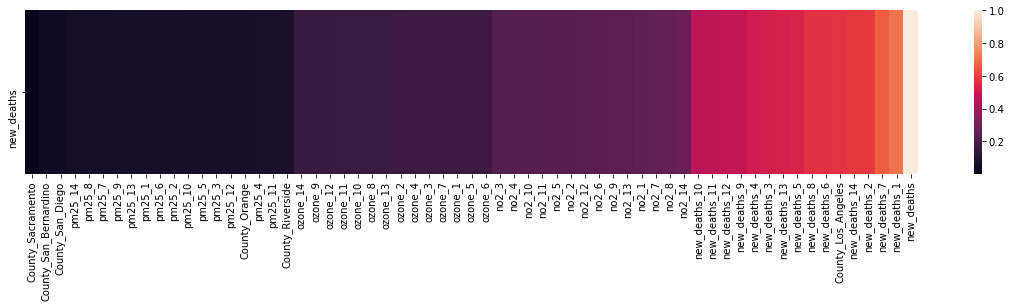

In [526]:
df_corr = clean_df.corr()[['new_deaths']].sort_values('new_deaths')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,3))
sns.heatmap(df_corr[df_corr['new_deaths']>0].T, ax=ax)

## Train/test splitting

In [527]:
X = clean_df[[col for col in clean_df.columns if col not in ['new_deaths', 'new_cases']]]
y = clean_df[['new_deaths', 'Date']]

In [528]:
use_random = True

if use_random:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
else:
    dt = (datetime.strptime(df['Date'].iloc[-1], '%Y-%m-%d') - datetime.strptime(df['Date'].iloc[0], '%Y-%m-%d')).days
    val_split = int(dt * .8)
    val_split_date = datetime.strptime(df['Date'].iloc[0], '%Y-%m-%d') + timedelta(days=val_split)
    val_split_date_str = datetime.strftime(val_split_date, '%Y-%m-%d')
    test_split = int(dt * .9)
    test_split_date = datetime.strptime(df['Date'].iloc[0], '%Y-%m-%d') + timedelta(days=test_split)
    test_split_date_str = datetime.strftime(test_split_date, '%Y-%m-%d')
    X_train = X[X['Date'] < test_split_date_str]
    X_test = X[X['Date'] > test_split_date_str]
    y_train = y[y['Date'] < test_split_date_str]
    y_test = y[y['Date'] > test_split_date_str]
    
X_train = X_train.drop('Date', axis=1)
X_test = X_test.drop('Date', axis=1)
y_train = y_train.drop('Date', axis=1)
y_test = y_test.drop('Date', axis=1)

Mean deaths: 2.3354743989722886


<AxesSubplot:ylabel='Frequency'>

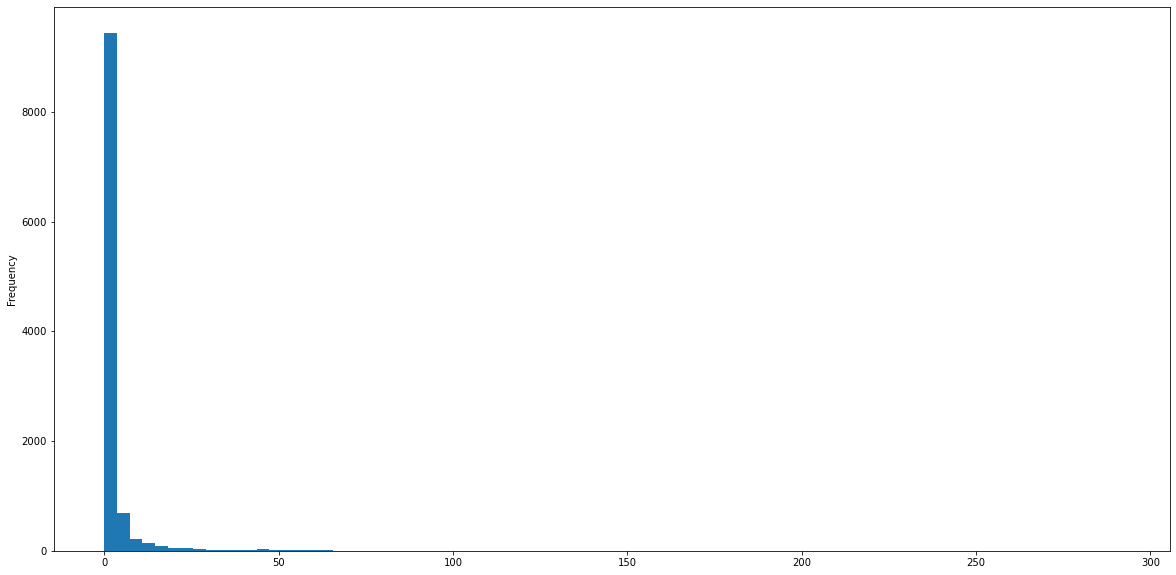

In [489]:
new_deaths_mean = y['new_deaths'].mean()
print(f'Mean deaths: {new_deaths_mean}')
y['new_deaths'].plot.hist(bins=80)

# Machine Learning Models

## Linear Regression

In [490]:
linr = LinearRegression()
linr.fit(X_train, y_train)
linr_prediction = linr.predict(X_test)

In [491]:
print("The Explained Variance: %.2f" % lr.score(X_test, y_test))
print("The MAE: %.2f deaths" % mean_absolute_error(y_test, linr_prediction))
print("The MSRE: %.2f deaths" % np.sqrt(mean_squared_error(y_test, linr_prediction)))
print("The Median Absolute Error: %.2f deaths" % median_absolute_error(y_test, linr_prediction))

The Explained Variance: 0.39
The MAE: 2.01 deaths
The MSRE: 5.67 deaths
The Median Absolute Error: 0.75 deaths


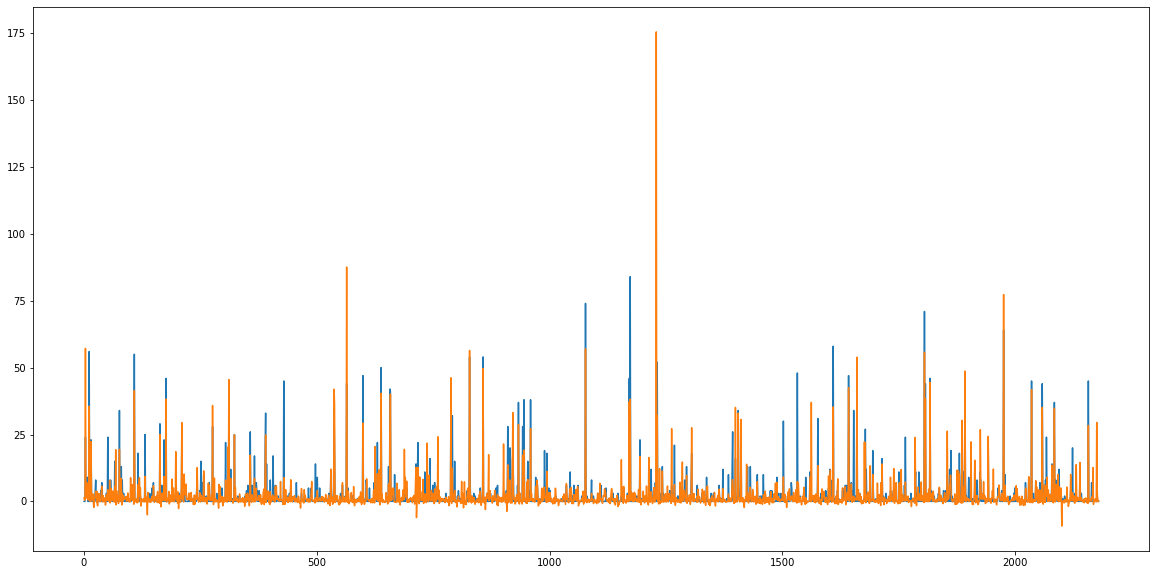

In [492]:
smooth_pred = savgol_filter(linr_prediction.ravel(), 13, 2)
smooth_y = savgol_filter(y_test['new_deaths'].values.ravel(), 13, 2)

y_actual = y_test['new_deaths'].values
plt.rcParams['figure.figsize'] = [20,10]
# plot results
plt.plot(y_actual)
plt.plot(lr_prediction)

# plot smoothed
# plt.plot(smooth_y)
# plt.plot(smooth_pred)

# plot differences
# plt.fill_between(range(100,1000), smooth_pred[100:1000], smooth_y[100:1000], where=smooth_y[100:1000] >= smooth_pred[100:1000], facecolor='green')
# plt.fill_between(range(100,1000), smooth_pred[100:1000], smooth_y[100:1000], where=smooth_y[100:1000] <= smooth_pred[100:1000], facecolor='red')


## Logistic Regression

In [493]:
logr = LogisticRegression(random_state=42)
logr.fit(X_train, y_train)
logr_prediction = logr.predict(X_test)

/opt/miniconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/miniconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [494]:
print("The Explained Variance: %.2f" % logr.score(X_test, y_test))
print("The MAE: %.2f deaths" % mean_absolute_error(y_test, logr_prediction))
print("The MSRE: %.2f deaths" % np.sqrt(mean_squared_error(y_test, logr_prediction)))
print("The Median Absolute Error: %.2f deaths" % median_absolute_error(y_test, logr_prediction))

The Explained Variance: 0.67
The MAE: 1.93 deaths
The MSRE: 5.76 deaths
The Median Absolute Error: 0.00 deaths


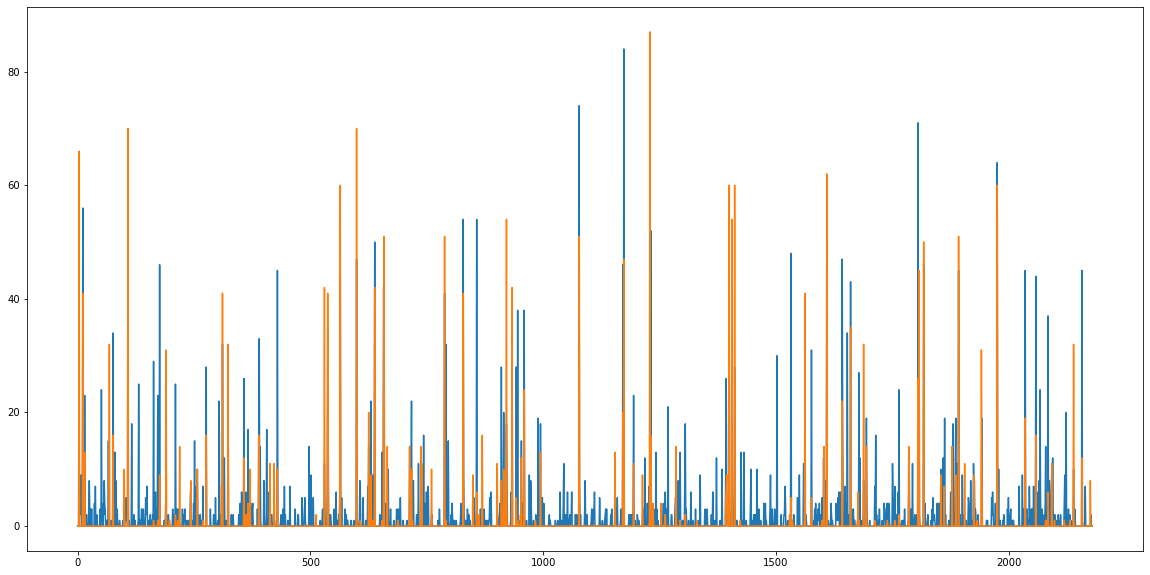

In [495]:
smooth_pred = savgol_filter(logr_prediction.ravel(), 21, 2)
smooth_y = savgol_filter(y_test['new_deaths'].values.ravel(), 21, 2)

y_actual = y_test['new_deaths'].values
plt.rcParams['figure.figsize'] = [20,10]
# plot results
plt.plot(y_actual)
plt.plot(logr_prediction)

# plot smoothed
# plt.plot(smooth_y)
# plt.plot(smooth_pred)
# plt.plot(smooth_y)
# plt.plot(smooth_pred)

# plot differences
# plt.fill_between(range(100,1000), smooth_pred[100:1000], smooth_y[100:1000], where=smooth_y[100:1000] >= smooth_pred[100:1000], facecolor='green')
# plt.fill_between(range(100,1000), smooth_pred[100:1000], smooth_y[100:1000], where=smooth_y[100:1000] <= smooth_pred[100:1000], facecolor='red')
plt.show()

## Random Forest

In [496]:
gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=1)
    
grid_result = gsc.fit(X_train, y_train.values.ravel())
best_params = grid_result.best_params_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 16.2min finished


In [497]:
rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], random_state=False)
scores = cross_val_score(rfr, X_train, y_train.values.ravel(), cv=10, scoring='neg_mean_absolute_error')

In [498]:
rfr.fit(X_train, y_train.values.ravel())

RandomForestRegressor(max_depth=6, random_state=False)

In [499]:
rfr_prediction = rfr.predict(X_test)

In [500]:
print("The Explained Variance: %.2f" % rfr.score(X_test, y_test))
print("The MAE: %.2f deaths" % mean_absolute_error(y_test, rfr_prediction))
print("The RMSE: %.2f deaths" % np.sqrt(mean_squared_error(y_test, rfr_prediction)))
print("The Median Absolute Error: %.2f deaths" % median_absolute_error(y_test, rfr_prediction))

The Explained Variance: 0.70
The MAE: 1.67 deaths
The RMSE: 4.00 deaths
The Median Absolute Error: 0.41 deaths


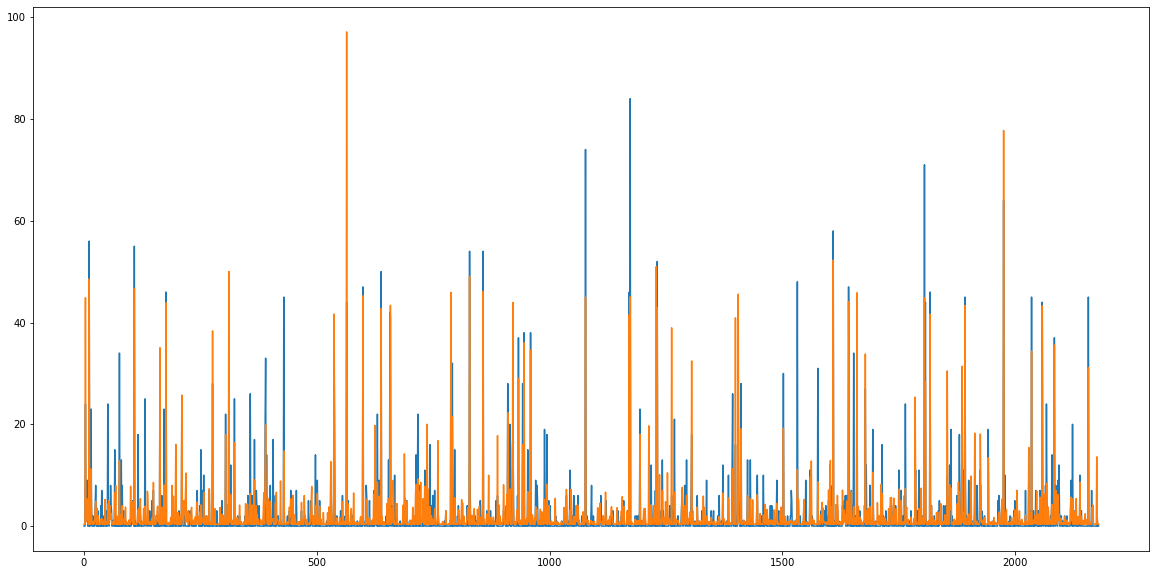

In [501]:
smooth_pred = savgol_filter(rfr_prediction.ravel(), 21, 2)
smooth_y = savgol_filter(y_test['new_deaths'].values.ravel(), 21, 2)

y_actual = y_test['new_deaths'].values
plt.rcParams['figure.figsize'] = [20,10]
# plot results
plt.plot(y_actual)
plt.plot(rfr_prediction)

# plot smoothed
# plt.plot(smooth_y)
# plt.plot(smooth_pred)

# plot differences
# plt.fill_between(range(0,len(smooth_pred)), prediction, y_actual, where=y_actual >= prediction, facecolor='green')
# plt.fill_between(range(0,len(smooth_pred)), prediction, y_actual, where=y_actual <= prediction, facecolor='red')
plt.show()

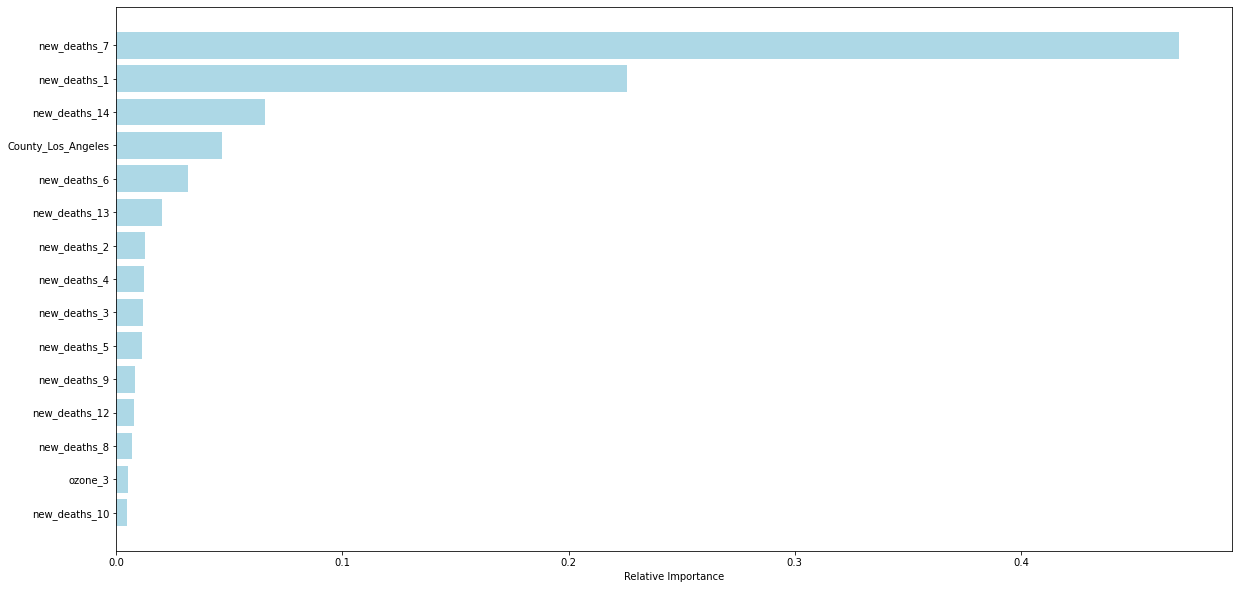

In [502]:
features = X_train.columns.values
importances = rfr.feature_importances_
indices = np.argsort(importances)[-15:]

plt.barh(range(len(indices)), importances[indices], color='lightblue', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

## Models analysis

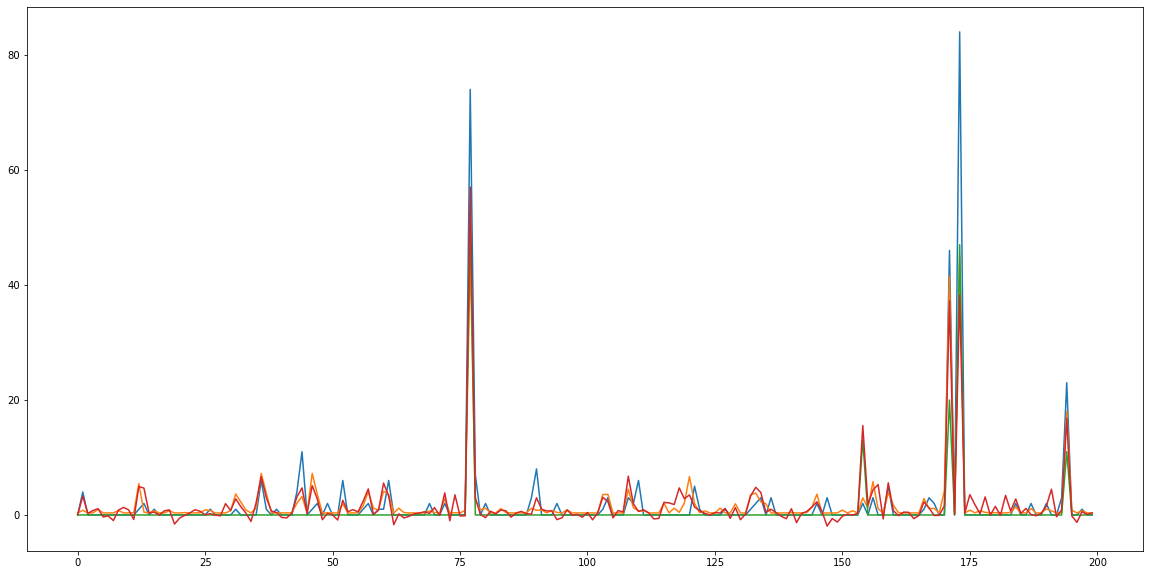

In [503]:
smooth_pred = savgol_filter(rfr_prediction.ravel(), 21, 2)
smooth_y = savgol_filter(y_test['new_deaths'].values.ravel(), 21, 2)

y_actual = y_test['new_deaths'].values
plt.rcParams['figure.figsize'] = [20,10]
# plot results
plt.plot(y_actual[1000:1200])
plt.plot(rfr_prediction[1000:1200])
plt.plot(logr_prediction[1000:1200])
plt.plot(lr_prediction[1000:1200])




# plot smoothed
# plt.plot(smooth_y)
# plt.plot(smooth_pred)

# plot differences
# plt.fill_between(range(0,len(smooth_pred)), prediction, y_actual, where=y_actual >= prediction, facecolor='green')
# plt.fill_between(range(0,len(smooth_pred)), prediction, y_actual, where=y_actual <= prediction, facecolor='red')
plt.show()

<AxesSubplot:ylabel='Frequency'>

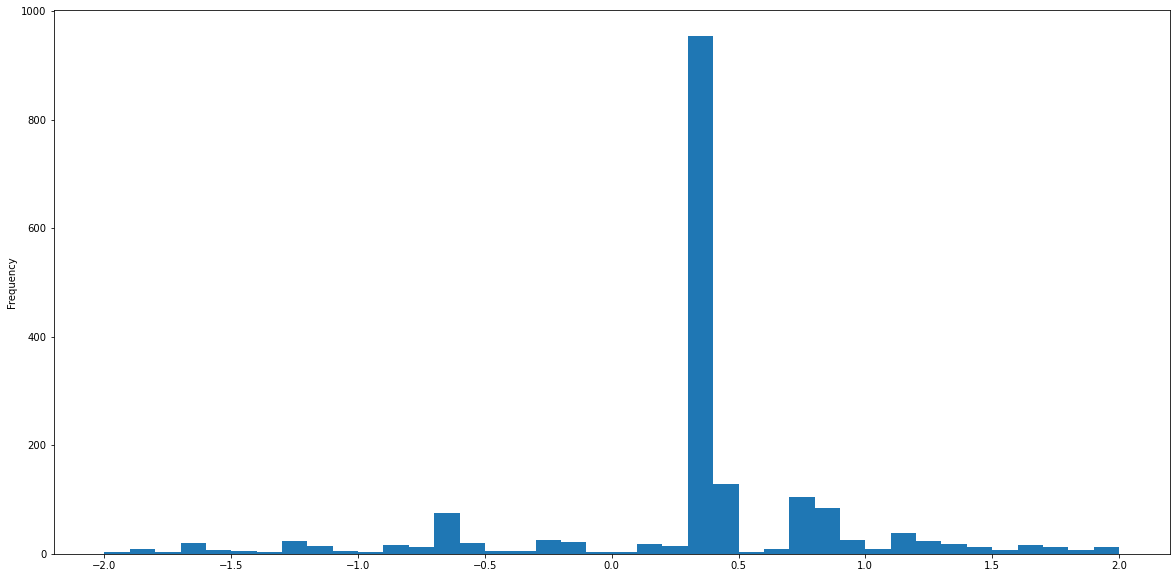

In [504]:
diff = rfr_prediction - y_test['new_deaths']
diff.plot.hist(bins=40, range=(-2,2))

In [505]:
abs(diff[abs(diff)<10]).mean()

1.1740756423482712

<AxesSubplot:>

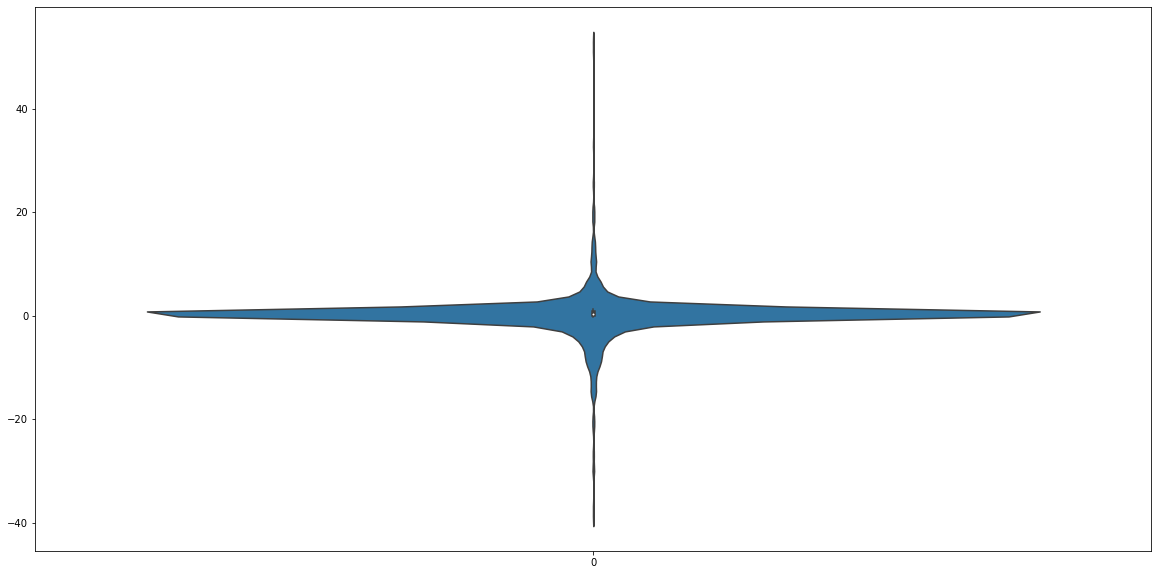

In [506]:
sns.violinplot(data=diff.values)

(-1.0, 10.0)

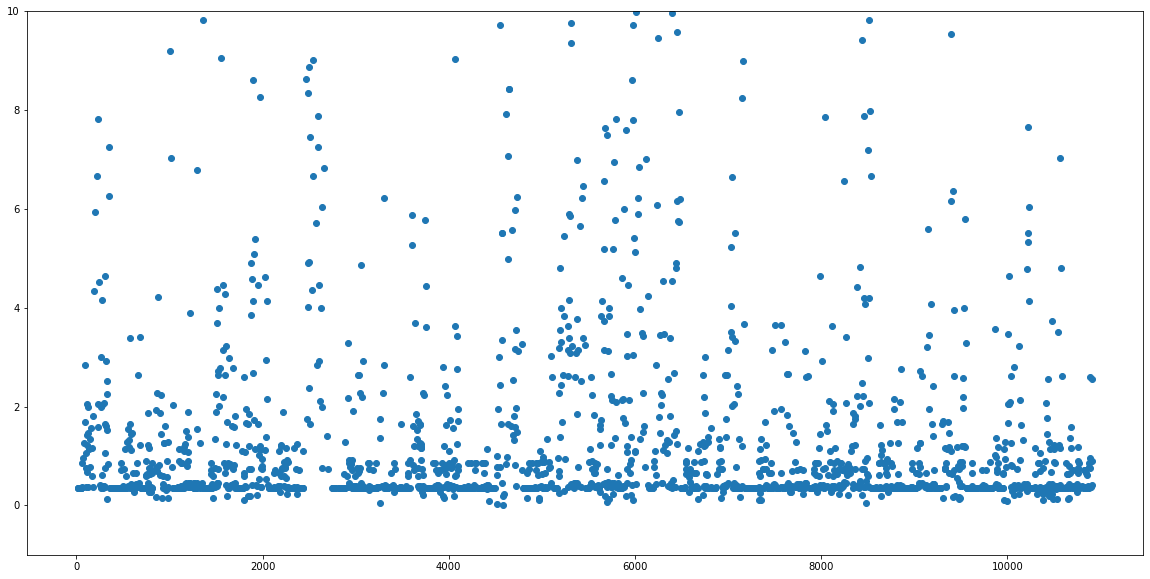

In [514]:
plt.plot(abs(diff),marker='o',linestyle='')
plt.ylim(-1, 10)

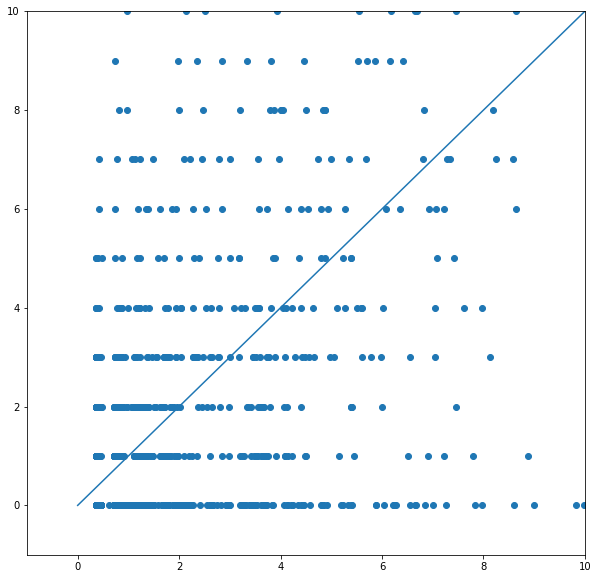

In [508]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
colors = np.random.rand(2180)
plt.scatter(rfr_prediction, y_test['new_deaths'])
plt.xlim(-1, 10)
plt.ylim(-1, 10)
ident = [0.0, 80]
plt.plot(ident,ident)


In [511]:
(y_test['new_deaths'] < 0).sum()

0